In [1]:
from google.colab import files
import pandas as pd
import numpy as np

In [2]:
#Mount my Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/My Drive/APM_B10/train.csv"
df = pd.read_csv(path)
df.head()

,id,url,landmark_id
0,97c0a12e07ae8dd5,http://lh4.ggpht.com/-f8xYA5l4apw/RSziSQVaABI/...,6347
1,650c989dd3493748,https://lh5.googleusercontent.com/-PUnMrX7oOyA...,12519
2,05e63ca9b2cde1f4,http://mw2.google.com/mw-panoramio/photos/medi...,264
3,08672eddcb2b7c93,http://lh3.ggpht.com/-9fgSxDYwhHA/SMvGEoltKTI/...,13287
4,fc49cb32ef7f1e89,http://lh6.ggpht.com/-UGAXxvPbr98/S-jGZbyMIPI/...,4018


In [4]:
filtered = df.groupby('landmark_id')['url'].filter(lambda x: len(x) >= 100)
df_filter = df[df['url'].isin(filtered)]
df_filter = df_filter.replace(to_replace='None', value=np.nan).dropna()
df_filter

,id,url,landmark_id
0,97c0a12e07ae8dd5,http://lh4.ggpht.com/-f8xYA5l4apw/RSziSQVaABI/...,6347
1,650c989dd3493748,https://lh5.googleusercontent.com/-PUnMrX7oOyA...,12519
2,05e63ca9b2cde1f4,http://mw2.google.com/mw-panoramio/photos/medi...,264
5,056708de792326b9,https://lh3.googleusercontent.com/-nbz_XT1dGz4...,5046
6,6ae1e206c579f649,https://lh6.googleusercontent.com/-onL5-pK9nZI...,5554
...,...,...,...
1225024,4bb5a501e5b26a6a,https://lh6.googleusercontent.com/-mRrQU3t5cYw...,9737
1225025,2cd8a404796cfe0e,https://lh6.googleusercontent.com/-0UB5gFx6w7M...,7758
1225026,8733b8b469fb8c1b,http://lh3.ggpht.com/-TDQWNVvJQDI/SI3HZSA4D3I/...,13170
1225027,14dd9e8790397c83,https://lh4.googleusercontent.com/-anV4Xpo0UuM...,5669


In [5]:
#Select only id from 1000-2000 to save time
landmark_list = [str(x) for x in list(range(1000,2000))]
data_sample = df_filter[df_filter['landmark_id'].isin(landmark_list)]
data_sample.landmark_id.value_counts()

1553    7653
1878    2285
1847    1642
1946    1533
1602    1466
        ... 
1771     103
1930     102
1135     102
1458     102
1879     100
Name: landmark_id, Length: 131, dtype: int64

In [6]:
#Ref: https://www.kaggle.com/lyakaap/fast-resized-image-download-python-3
import re
TARGET_SIZE = 96 #imports images of resolution 96x96

'''change URLs to resize images to target size'''
def overwrite_urls(df):
    def reso_overwrite(url_tail, reso=TARGET_SIZE):
        pattern = 's[0-9]+'
        search_result = re.match(pattern, url_tail)
        if search_result is None:
            return url_tail
        else:
            return 's{}'.format(reso)
    
    def join_url(parsed_url, s_reso):
        parsed_url[-2] = s_reso
        return '/'.join(parsed_url)
    
    df = df[df.url.apply(lambda x: len(x.split('/'))>1)]
    parsed_url = df.url.apply(lambda x: x.split('/'))
    train_url_tail = parsed_url.apply(lambda x: x[-2])
    resos = train_url_tail.apply(lambda x: reso_overwrite(x, reso=TARGET_SIZE))

    overwritten_df = pd.concat([parsed_url, resos], axis=1)
    overwritten_df.columns = ['url', 's_reso']
    df['url'] = overwritten_df.apply(lambda x: join_url(x['url'], x['s_reso']), axis=1)
    return df

data_sample_resize = overwrite_urls(data_sample)
print ('1. URLs overwritten')

1. URLs overwritten


In [7]:
train_dir = r'/content/drive/My Drive/APM_B10/N_train_images_model/'
validation_dir = r'/content/drive/My Drive/APM_B10/M_validation_images_model/'
test_dir = r'/content/drive/My Drive/APM_B10/N_test_images_from_train/'

In [8]:
import os 
import zipfile 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

In [9]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
BATCH_SIZE = 240
IMG_SIZE = (96,96)

train_dataset = image_dataset_from_directory(train_dir,
                                             labels='inferred',
                                             label_mode='categorical',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory(validation_dir,
                                             labels='inferred',
                                             label_mode='categorical',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(test_dir,
                                            labels='inferred',
                                            label_mode='categorical',
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 36475 files belonging to 131 classes.
Found 9591 files belonging to 131 classes.
Found 439 files belonging to 131 classes.


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [11]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./95.)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1.0/95.)

In [12]:
# Flow training images in batches of 240 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 240, target_size = (96, 96))

# Flow validation images in batches of 240 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(validation_dir,  batch_size = 240, target_size = (96, 96))

Found 36475 images belonging to 131 classes.
Found 9591 images belonging to 131 classes.


In [13]:
len(train_generator)

152

# Inception Model#

In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception_model = InceptionV3(input_shape = (96, 96, 3), include_top = False, weights = 'imagenet')

87916544/87910968 [==============================] - 2s 0us/step


In [15]:
for layer in inception_model.layers:
    layer.trainable = False

In [16]:
x = inception_model.output
x = layers.Flatten()(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(131, activation="softmax",name="predictions")(x)
inception_model = tf.keras.models.Model(inputs = inception_model.input, outputs = predictions)

In [17]:
def top_1_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=1)

inception_model.compile(tf.keras.optimizers.RMSprop(lr=0.01, decay=1e-6),loss='categorical_crossentropy',metrics=[top_1_accuracy])

In [18]:
inc_history = inception_model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 20, epochs = 10)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/10
20/20 [==============================] - 4238s 212s/step - loss: 26.2894 - top_1_accuracy: 0.0615 - val_loss: 4.4874 - val_top_1_accuracy: 0.0657
Epoch 2/10
20/20 [==============================] - 1263s 63s/step - loss: 4.8367 - top_1_accuracy: 0.0625 - val_loss: 4.4327 - val_top_1_accuracy: 0.0939
Epoch 3/10
20/20 [==============================] - 1105s 55s/step - loss: 4.7334 - top_1_accuracy: 0.0669 - val_loss: 4.3842 - val_top_1_accuracy: 0.1030
Epoch 4/10
20/20 [==============================] - 951s 48s/step - loss: 4.6007 - top_1_accuracy: 0.0917 - val_loss: 4.2664 - val_top_1_accuracy: 0.1718
Epoch 5/10
20/20 [==============================] - 859s 43s/step - loss: 4.5168 - top_1_accuracy: 0.1117 - val_loss: 4.3452 - val_top_1_accuracy: 0.1179
Epoch 6/10
20/20 [==============================] - 732s 37s/step - loss: 4.4570 - top_1_accuracy: 0.1123 - val_loss: 3.9523 - val_top_1_accuracy: 0.1875
Epoch 7/10
20/20 [==============================] - 620s 31s/step - los

In [19]:
#predictions
loss, accuracy = inception_model.evaluate(test_dataset)

2/2 [==============================] - 1s 547ms/step - loss: 11.1110 - top_1_accuracy: 0.1116


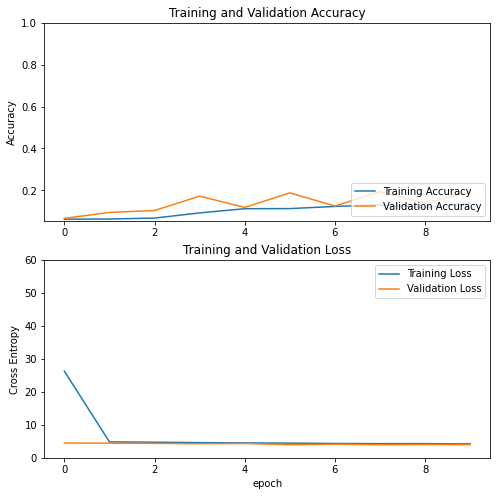

In [23]:
#loss curve
acc = inc_history.history['top_1_accuracy']
val_acc = inc_history.history['val_top_1_accuracy']

loss = inc_history.history['loss']
val_loss = inc_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,60.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#run this cell so there is no timeout while the model running
#while True:
   # pass

KeyboardInterrupt: ignored